# Portfolio Analyzer overview

Portfolio Analyzer is a python library built to make easy portfolio analysis. In this Notebook we are going to see few examples. First things first. You can install Portfolio Analyzer with pip, so

In [1]:
#%%bash
#pip install git+https://github.com/Tokukawa/PortfolioAnalyzer.git

The first thing we need in order to analyze porfolio is data. We can use the function `yahoo2pandas`. This function take a list of tickers and return a pandas dataframe

In [2]:
from portfolio_analyzer.stocks_data_loader import yahoo2pandas

In [3]:
tickers = ['VTI', 'VEDTX', 'IAU']
data = yahoo2pandas(tickers, frequency='monthly')

In [4]:
data.head()

,VTI,VEDTX,IAU
formatted_date,,,
2007-11-01,73.474998,30.040001,7.749
2007-12-01,72.574997,29.500000,8.245
2008-01-01,68.099998,29.709999,9.150
2008-02-01,66.400002,29.059999,9.636
2008-03-01,65.500000,30.059999,9.067


By default `yahoo2pandas` return all possible data from yahoo. You can specify range of time you want and the frequency. Once we obtained the data, we can optimize our portfolio according to some most common algorithms. Up this moment you can use only `minimal_variance`, `risk_parity` and `approximated_max_kelly`.

In [5]:
from portfolio_analyzer.optimizers import approximated_max_kelly, minimal_variance, risk_parity

In [6]:
minimal_variance(data)

,VTI,VEDTX,IAU
0,0.527158,0.26435,0.208493


In [7]:
risk_parity(data)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 8.392595253381849e-14
            Iterations: 16
            Function evaluations: 80
            Gradient evaluations: 16


,VTI,VEDTX,IAU
0,0.443144,0.278195,0.278661


In [8]:
approximated_max_kelly(data)

,VTI,VEDTX,IAU
0,0.551316,0.225247,0.223436


We can see how our portfolio would perform with `NaiveBackTest`.

In [9]:
from portfolio_analyzer.backtest import NaiveBackTest
from portfolio_analyzer.utils import portfolio2dic

In [10]:
my_portfolio = portfolio2dic(approximated_max_kelly(data))

In [11]:
backtest = NaiveBackTest(my_portfolio, data)

In [12]:
risk_parity_backtest = backtest.run()

We can perform some measures on the back test and we can plot it.

In [13]:
%matplotlib inline
from portfolio_analyzer.metrics import MainMetrics

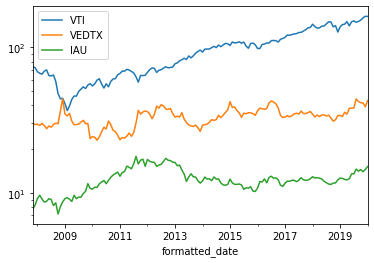

In [14]:
data.plot(logy=True)

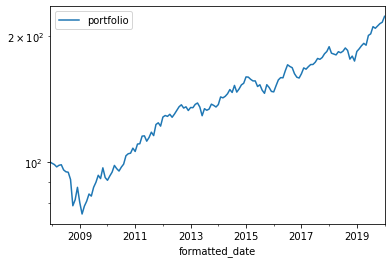

In [15]:
risk_parity_backtest.plot(logy=True)

In [16]:
benchmark_data = yahoo2pandas(['VTI'], frequency='monthly')
#benchmark_data = data[['QQQ']]
measures = MainMetrics(benchmark=benchmark_data)

In [17]:
MainMetrics(benchmark_data).estimate(risk_parity_backtest)

,portfolio
alpha,0.035251
average return,0.067162
benchmark correlation,0.701332
beta,0.451054
max draw down,-0.249499
sharpe ratio,0.209614


Now that we are happy with our portfolio, we can rabalance it in function of the market current fluctuations.

In [18]:
from portfolio_analyzer.balancer import Rebalance

In [19]:
portfolio_exposure = {  # the number of stock I have currently in my portfolio.
    'VTI': 11, 
    'TLT': 22, 
    'GLD': 33
}

extra_cash = 123.

optimal_weights = portfolio2dic(approximated_max_kelly(data))

In [20]:
rebalancer = Rebalance(portfolio_exposure, optimal_weights, extra_cash)

In [21]:
new_exposure, current_balance = rebalancer.compute()

In [22]:
new_exposure, current_balance

({'VTI': 34, 'VEDTX': 53, 'IAU': 148}, 10059.409973144531)

Now I know how much I should sell or buy of every ticker:

In [23]:
rebalancer.diff(new_exposure)

{'VEDTX': 53, 'GLD': -33, 'VTI': 23, 'IAU': 148, 'TLT': -22}

But I want to perform a proper out-of-sample back test before rebalancing my portfolio. We can use the class `OutOfSampleBackTest`. First of all we need to know how many times we can split the dataset.

In [24]:
from portfolio_analyzer.utils import factors

In [25]:
factors(len(data))

[1, 3, 7, 21, 49, 147]

Now we can make a proper outofsample backtest.

In [26]:
from portfolio_analyzer.backtest import OutOfSampleBackTest

In [27]:
SPLITS = 7
oos_backtest = OutOfSampleBackTest(data, minimal_variance, SPLITS, method='equal-blocks')

In [28]:
out_of_sample_portfolio = oos_backtest.run()

We can get the actual out of sample performance the same way we did before.

In [29]:
MainMetrics(benchmark_data).estimate(out_of_sample_portfolio)

,portfolio
alpha,0.057651
average return,0.105950
benchmark correlation,0.630541
beta,0.397226
max draw down,-0.100294
sharpe ratio,0.357819


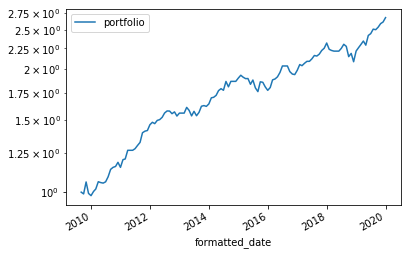

In [30]:
out_of_sample_portfolio.plot(logy=True)

I can even detect trends. For trend detection we can use the function l1filter.

In [31]:
from portfolio_analyzer.filtering import l1filter

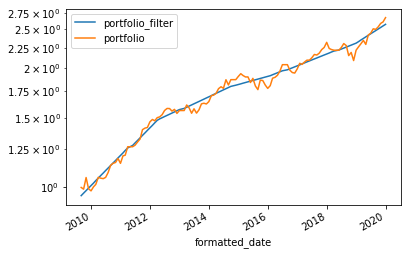

In [45]:
filtered, test = l1filter(out_of_sample_portfolio, delta=1E0)
filtered.plot(logy=True)

In [46]:
filtered.head()

,portfolio_filter,portfolio
formatted_date,,
2009-09-01,0.953654,1.000000
2009-10-01,0.967639,0.990106
2009-11-01,0.981830,1.059203
2009-12-01,0.996229,0.992844
2010-01-01,1.010839,0.980463


Whenever we perform a trend detection the test of stationarity is performed on the residuals. We can see the statistics as a pandas dataframe.

In [47]:
test['portfolio']

,portfolio
ADF Test Statistic,-4.606933
P-Value,0.000125
Lags Used,0.000000
Observations Used,119.000000
Critical Value (1%),-3.486535
Critical Value (5%),-2.886151
Critical Value (10%),-2.579896


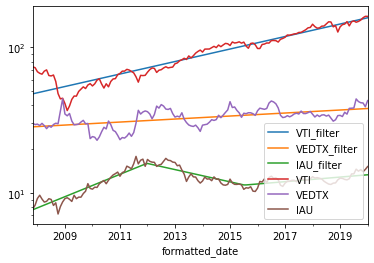

In [35]:
filtered, test = l1filter(data, delta=[1E4, 1E4, 1E1])
filtered.plot(logy=True)

In [36]:
test.keys()

dict_keys(['VTI', 'VEDTX', 'IAU'])

In [37]:
test['VTI']

,VTI
ADF Test Statistic,-3.856921
P-Value,0.002376
Lags Used,0.000000
Observations Used,146.000000
Critical Value (1%),-3.475953
Critical Value (5%),-2.881548
Critical Value (10%),-2.577439
